In [1]:
import matplotlib.pyplot as plt
import numpy as np
import struct
import time
import cv2
from os import walk

import keras
from keras.datasets import mnist
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, merge
from keras.layers import Conv2D, MaxPooling2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

from keras.utils import to_categorical
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Prepare for reading images
train_files = []
for (dirpath, dirnames, filenames) in walk("./train/img/"):
    train_files.extend(filenames)
    break

test_files = []
for (dirpath, dirnames, filenames) in walk("./test/img/"):
    test_files.extend(filenames)
    break

(8, 40, 40)


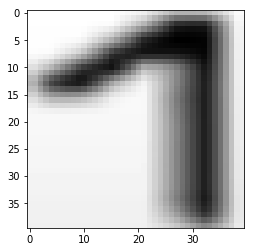

In [3]:
def extract_digit_image(filename):
    '''
    Read license plate from a given file location and 
    extract separated, sorted and resized character images with opencv
    '''
    detected = []
    im = plt.imread(filename)
    im = cv2.imread(filename)
    im = cv2.resize(im,(300,80))

    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(imgray, 127, 255, 0)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # get rectangle bounding contour
        (x,y,w,h) = cv2.boundingRect(contour)

        # discard areas that are too large
        if h > 60 and w > 60:
            pass
            continue

        # discard areas that are too small
        if h < 30 or w < 10:
            pass
            continue

        # draw rectangle around contour on original image
        # plt.imshow(imgray[x:x+w,y:y+h])

        detected.append((x,y,w,h))

    detected = sorted(detected)

    last_x = -100
    r = []
    for i in detected:
        (x,y,w,h) = i
        if(np.abs(x - last_x) < 8):
            continue
        last_x = x
        r.append(cv2.resize(imgray[y:y+h,x:x+w],(40,40)))
        cv2.rectangle(imgray, (x,y), (x+w, y+h), (0, 255, 0), 2)

    return r


test1_plate = extract_digit_image("./train/img/"+train_files[5])

print(np.array(test1_plate).shape)
plt.imshow(test1_plate[6],cmap=plt.cm.gray)

In [4]:
# Flatten the training images and labels as inputs and targets for neural network
pre_x_train = [extract_digit_image("./train/img/"+train_files[i]) for i in range(len(train_files))]
print(np.array(pre_x_train[3]).shape)
print(np.array(pre_x_train).shape)

x_train = []
for i in range(len(pre_x_train)):
    for j in range(len(pre_x_train[i])):
        x_train.append(pre_x_train[i][j])
x_train = np.array(x_train)

y_train = []
for i in range(len(train_files)):
    chars = list()
    for j in train_files[i]:
        chars.append(j)
    y_train.append(chars[:-4])
    
y_train = np.array(y_train)
y_train = np.ndarray.flatten(y_train)

(8, 40, 40)
(6965,)


(55763, 40, 40)


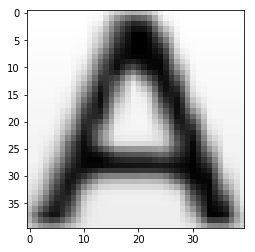

A


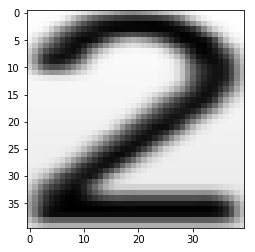

2


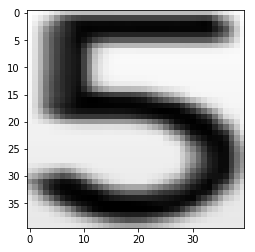

5


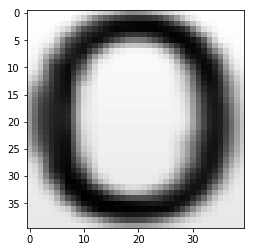

0


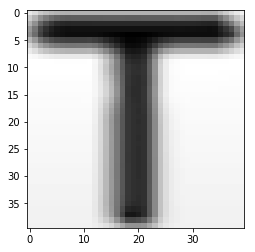

T


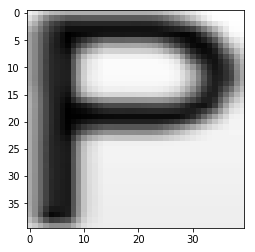

P


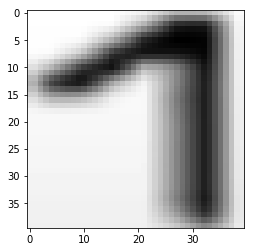

1


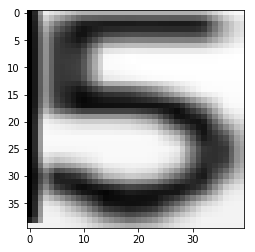

5


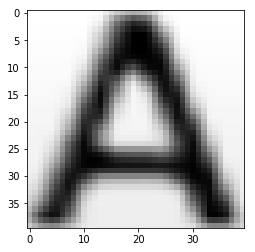

A


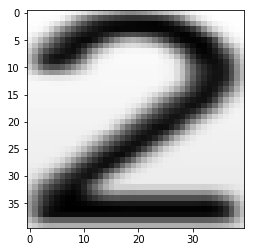

2


In [5]:
print(x_train.shape)
for i in range(2000,2010):
    plt.imshow(x_train[i], cmap = plt.cm.gray)
    plt.show()
    print(y_train[i])

In [6]:
pre_x_test = [extract_digit_image("./test/img/"+test_files[i]) for i in range(len(test_files))]

x_test = []
for i in range(len(pre_x_test)):
    for j in range(len(pre_x_test[i])):
        x_test.append(pre_x_test[i][j])
x_test = np.array(x_test)

y_test = []
for i in range(len(test_files)):
    chars = list()
    for j in test_files[i]:
        chars.append(j)
    y_test.append(chars[:-4])
    
y_test = np.array(y_test)
y_test = np.ndarray.flatten(y_test)

In [7]:
# string labels to numerical codes
letters = list(map(chr, range(65, 91))) + list(map(chr, range(48, 58)))

def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

y_train = text_to_labels(y_train)
y_test = text_to_labels(y_test)

In [8]:
train_size = 5000
test_size = 500

print(y_train[1])
print(x_train[:train_size][7].shape)

categorized_trainLabel = to_categorical(y_train[:train_size])
categorized_testLabel = to_categorical(y_test[:test_size])

training_input = x_train[:train_size].reshape(-1,40,40,1)
training_input = training_input.astype('float32')/255

test_input = x_test[:test_size].reshape(-1,40,40,1)
test_input = test_input.astype('float32')/255

26
(40, 40)


In [9]:
batch_size = 64
epochs = 20
num_classes = 36

# Conv2D 32 -> ReLU -> MaxPooling 2,2 -> Conv2D 64 ->ReLU -> MaxPooling 2,2 -> 
# Conv2D 128 -> ReLU -> MaxPooling 2,2 -> Flatten -> Fully Connected layers
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(40,40,1),padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D((2, 2),padding='same'))
model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(LeakyReLU(alpha=0.1))                  
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])

model.summary()

train = model.fit(training_input, categorized_trainLabel, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(test_input, categorized_testLabel))

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 40, 40, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 40, 40, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv

-------------- Input License Plate --------------
The OCR result:  P730EO50


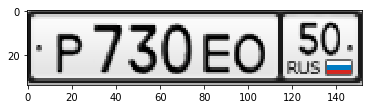

In [13]:
# Showcase 
rand_num = np.random.randint(0, 10001)
validation_showcase_file = "./train/img/"+train_files[rand_num]
# print(validation_showcase_file)
print("-------------- Input License Plate --------------")
im = plt.imread(validation_showcase_file)
plt.imshow(im,cmap="gray")


# Doing things in the background
showcase1 = extract_digit_image(validation_showcase_file)
temporary_storage = []
# temporary_storage = model.predict_classes(showcase1)
for i in range(len(showcase1)):
    temporary_storage.append(model.predict(np.array(showcase1[i]).reshape(-1,40,40,1)))
    
# print(np.argmax(temporary_storage[1]))
# print("Letters: ", letters)

showcase_label = labels_to_text([np.argmax(temporary_storage[i]) for i in range(len(temporary_storage))])
print("The OCR result: ",showcase_label)

_________________Homemade wraping solution_________________
OG image


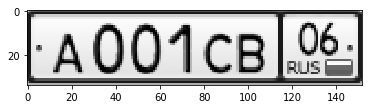

height= 34 , width= 152
Resized image


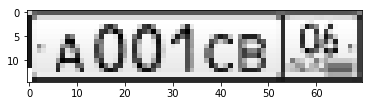

height= 15 , width= 70
Time elapsed:  0.46175146102905273
OG image


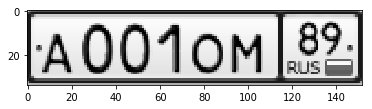

height= 34 , width= 152
Resized image


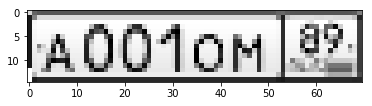

height= 15 , width= 70
Time elapsed:  0.44180870056152344
OG image


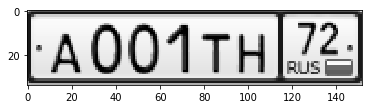

height= 34 , width= 152
Resized image


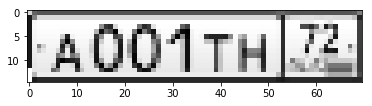

height= 15 , width= 70
Time elapsed:  0.4367055892944336


In [11]:
# Appendix I: One attempt for creating our own warping function to replace cv2.resize (Successful but slow)
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import pickle

#import helping function
from scipy.ndimage import zoom

def compute_homography(pts1,pts2):
    """
    Computes the 3x3 transformation matrix (homography) that when applied to pts1 yields pts2
    """

    #expected dimensions of input
    assert(pts1.shape[0]==2)
    assert(pts2.shape[0]==2)
    assert(pts1.shape[1]>=4)
    assert(pts2.shape[1]>=4)
    
    
    # get A in Ax = b
    n = pts1.shape[1] # n is number of points in each array
    A = np.zeros((2*n,8))
    for i in range(n): 
        A1 = [pts1[0][i], pts1[1][i], 1, 0, 0, 0, -pts2[0][i]*pts1[0][i], -pts2[0][i]*pts1[1][i]]
        A2 = [0, 0, 0, pts1[0][i], pts1[1][i], 1, -pts2[1][i]*pts1[0][i], -pts2[1][i]*pts1[1][i]]    
        A[2*i,:8] = A1
        A[1+2*i, :8] = A2
    
    # get b in Ax = b
    b = np.zeros((8,1))
    for i in range(4): 
        b[2*i] = pts2[0][i]
        b[1+2*i] = pts2[1][i]
    
    # get x and reshape it to be H
    H = np.linalg.lstsq(A, b, -1)
    H = H[0]
    H = np.append(H,[1.])
    H = np.reshape(H, (3,3))
    #
    
    #expected dimension of output
    assert (H.shape==(3,3))
    
    return H 


def apply_homography(H,pts):
    """
    Apply a specified homography H to a set of 2D point coordinates
    """

    #assert expected dimensions of input
    assert(H.shape==(3,3))
    assert(pts.shape[0]==2)
    assert(pts.shape[1]>=1)
    
    pad = np.ones(pts.shape[1])
    vecs = np.append(pts, pad)
    vecs = np.reshape(vecs, (pts.shape[0]+1,pts.shape[1]))
    m = np.matmul(H, vecs)
    
    # scale according to w
    m[0] /= m[2]
    m[1] /= m[2]
    
    tpts = m[:2]
    
    #make sure transformed pts are correct dimension
    assert(tpts.shape[0]==2)
    assert(tpts.shape[1]==pts.shape[1])
    
    return tpts

def warp_image(im, basepts, tarpts):
    #input pixel grid
    ogrid_y,ogrid_x = np.mgrid[0:tarpts[1][-1], 0:tarpts[0][-1]]
    igrid_y,igrid_x = np.mgrid[0:im.shape[0], 0:im.shape[1]] # y = rows, x = cols

    y = igrid_y.flatten()
    x = igrid_x.flatten()
    incoords = np.stack((x,y))

    # transform pixel coordinates
    hom = compute_homography(basepts, tarpts)
    warpedcoords = apply_homography(np.array(hom),incoords)


    # brightness values reshaped as a Nx1 array
    bvalues = im.flatten()
    wcoords = warpedcoords.transpose()

    # use griddata to warp 
    img_warped = griddata(wcoords,bvalues,(ogrid_x,ogrid_y))

    return img_warped

print("_________________Homemade wraping solution_________________")
for i in range(3):
    im = plt.imread("./train/img/"+train_files[i])
    im = im.mean(axis=-1)
    im = im/255
    plt.imshow(im,cmap="gray")
    print("OG image")
    plt.show()
    
    height = im.shape[0]
    width = im.shape[1]
    print("height=",height,", width=",width)

    # upperleft, lowerleft, upperright, lowerright
    original_boundary = np.array([[0,0],[0,height],[width,0], [width, height]]).T
    # Target dimension: height = 15, width = 70
    target_boundary = np.array([[0,0],[0,15.],[70.,0],[70.,15.]]).T
    
    # Timer start
    start = time.time()
    
    # warp image to resize
    wim = warp_image(im, original_boundary, target_boundary)
    plt.imshow(wim, cmap = "gray")
    print("Resized image")
    plt.show()
    print("height=",wim.shape[0],", width=",wim.shape[1])
    
    end = time.time()
    print("Time elapsed: ", end-start)

OG image


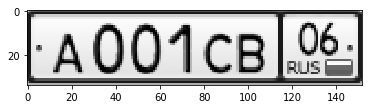

Resized image


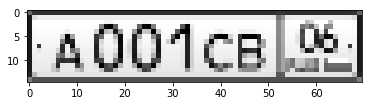

height= 15 , width= 70
Time elapsed:  0.13165283203125
OG image


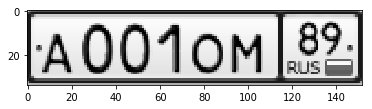

Resized image


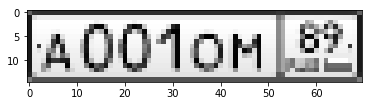

height= 15 , width= 70
Time elapsed:  0.14162158966064453
OG image


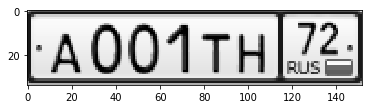

Resized image


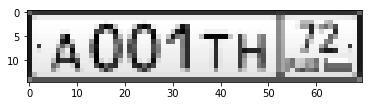

height= 15 , width= 70
Time elapsed:  0.12370085716247559


In [12]:
# Comparison to opencv
for i in range(3):
    im = plt.imread("./train/img/"+train_files[i])
    im = im.mean(axis=-1)
    im = im/255
    plt.imshow(im,cmap="gray")
    print("OG image")
    plt.show()
    
    # Timer start
    start = time.time()
    
    wim = cv2.resize(im,(70,15))
    plt.imshow(wim, cmap = "gray")
    print("Resized image")
    plt.show()
    print("height=",wim.shape[0],", width=",wim.shape[1])
    
    end = time.time()
    print("Time elapsed: ", end-start)